# ***Tarea 2. Análisis de Sentimientos***

**Dora Alicia Guevara Villalpando**  
**Procesamiento y clasificación de datos**  


**Requerimientos:**
1. Selección del conjunto de datos.
2. Método de vectorización.
3. Preprocesamiento: limpieza de texto (remoción de stop words, stemming, etc.), tokenización, y más.
4. Análisis de sentimiento.
5. Reporte.



In [2]:
import os
import re
import tarfile
import pandas as pd
import seaborn as sns
import requests
import nltk
import string
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [3]:
# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alicevillalpando/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicevillalpando/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicevillalpando/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Cargar el conjunto de datos.**

### **Conjunto de Datos: *IMDB Movie Reviews***  


**Visión General**  
Este conjunto de datos contiene reseñas de películas junto con sus etiquetas de polaridad de sentimiento binario asociadas. Está diseñado para servir como referencia en la clasificación de sentimientos. Este documento describe cómo se recopiló el conjunto de datos y cómo utilizar los archivos proporcionados.  


**Conjunto de Datos**  
El conjunto de datos principal contiene 50,000 reseñas, divididas equitativamente en 25,000 para entrenamiento y 25,000 para prueba. La distribución general de etiquetas está equilibrada (25,000 positivas y 25,000 negativas). Además, se incluyen 50,000 documentos adicionales sin etiquetas para el aprendizaje no supervisado.

En toda la colección, no se permiten más de 30 reseñas para una misma película, ya que las reseñas del mismo filme tienden a tener calificaciones correlacionadas. Además, los conjuntos de entrenamiento y prueba contienen películas diferentes, por lo que no se puede lograr un desempeño significativo simplemente memorizando términos únicos de cada película y sus etiquetas asociadas.

En los conjuntos de entrenamiento y prueba etiquetados:
- Una reseña negativa tiene una calificación de ≤ 4 en una escala de 10.
- Una reseña positiva tiene una calificación de ≥ 7 en una escala de 10.
- Las reseñas con calificaciones más neutrales no están incluidas en los conjuntos de entrenamiento y prueba.

**Link:** https://ai.stanford.edu/~amaas/data/sentiment/


**Nota.** A pesar que el conjunto de datos originalmente viene separado en *train* y *test* no se considera esto para realizar los análisis presentados a continuación; se opta por juntar ambos conjuntos y trabajar con uno completo con las 50,000 reseñas.


In [6]:
# URL del dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = "aclImdb_v1.tar.gz"
extracted_path = "aclImdb"

# Descarga del dataset
if not os.path.exists(dataset_path):
    print("Descargando el dataset... \n")
    response = requests.get(url, stream = True)
    with open(dataset_path, "wb") as file:
        for chunk in response.iter_content(chunk_size = 1024):
            if chunk:
                file.write(chunk)
    print("Descarga completada. \n")

# Descomprimir el archivo
if not os.path.exists(extracted_path):
    print("Descomprimiendo el dataset... \n")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall()
    print("Descompresión completada. \n")

# Función para cargar datos
def load_data(data_dir):
    data = []
    labels = []
    for label_type in ["pos", "neg"]:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith(".txt"):
                with open(os.path.join(dir_name, fname), "r", encoding = "utf-8") as file:
                    data.append(file.read())
                    labels.append(1 if label_type == "pos" else 0)
    return data, labels

# Cargar datos de entrenamiento y prueba
train_data, train_labels = load_data(os.path.join(extracted_path, "train"))
test_data, test_labels = load_data(os.path.join(extracted_path, "test"))

# Crear DataFrames
train_df = pd.DataFrame({"review": train_data, "sentiment": train_labels})
test_df = pd.DataFrame({"review": test_data, "sentiment": test_labels})

# Combinar datos de entrenamiento y prueba 
full_df = pd.concat([train_df, test_df], ignore_index = True)

# Mostrar información del dataset
print(f"Dataset cargado: {len(full_df)} muestras \n")
print(full_df.head())

# Guardar el DataFrame como CSV (opcional)
full_df.to_csv("imdb_reviews.csv", index = False)



Dataset cargado: 50000 muestras 

                                              review  sentiment
0  For a movie that gets no respect there sure ar...          1
1  Bizarre horror movie filled with famous faces ...          1
2  A solid, if unremarkable film. Matthau, as Ein...          1
3  It's a strange feeling to sit alone in a theat...          1
4  You probably all already know this by now, but...          1


**Clases originales:**  
- Negative - 0
- Positive - 1

In [8]:
full_df.head()

,review,sentiment
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [9]:
full_df.shape

(50000, 2)

## **Procesamiento de los datos**

In [11]:
# Función para limpiar HTML
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()


In [12]:
# Aplicar la limpieza de HTML a las reseñas
full_df["html_cleaned_review"] = full_df["review"].apply(clean_html)


/var/folders/ct/cf8v_6td4sjd6_m0d5bnd1mc0000gn/T/ipykernel_4779/1558803987.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [13]:
full_df.head()

,review,sentiment,html_cleaned_review
0,For a movie that gets no respect there sure ar...,1,For a movie that gets no respect there sure ar...
1,Bizarre horror movie filled with famous faces ...,1,Bizarre horror movie filled with famous faces ...
2,"A solid, if unremarkable film. Matthau, as Ein...",1,"A solid, if unremarkable film. Matthau, as Ein..."
3,It's a strange feeling to sit alone in a theat...,1,It's a strange feeling to sit alone in a theat...
4,"You probably all already know this by now, but...",1,"You probably all already know this by now, but..."


### **Signos de puntuación**

In [15]:
# Extraer la columna de reseñas sin HTML
reviews = full_df['html_cleaned_review']


In [16]:
# Conteo de signos de puntuación
punctuations = string.punctuation
punctuation_counts = Counter(char for review in reviews for char in review if char in punctuations)

# Mostrar conteo de signos de puntuación
print("Conteo de signos de puntuación:")
for punctuation, count in punctuation_counts.items():
    print(f"{punctuation}: {count}")
    

Conteo de signos de puntuación:
.: 650515
!: 49164
": 131856
(: 69585
': 263759
): 71267
,: 544818
&: 7693
-: 132038
*: 13916
/: 13757
:: 19799
?: 32336
>: 276
;: 13353
%: 867
#: 622
+: 642
`: 1861
|: 45
@: 181
$: 1617
=: 622
[: 239
]: 254
_: 997
~: 230
{: 192
}: 192
\: 35
<: 119
^: 95


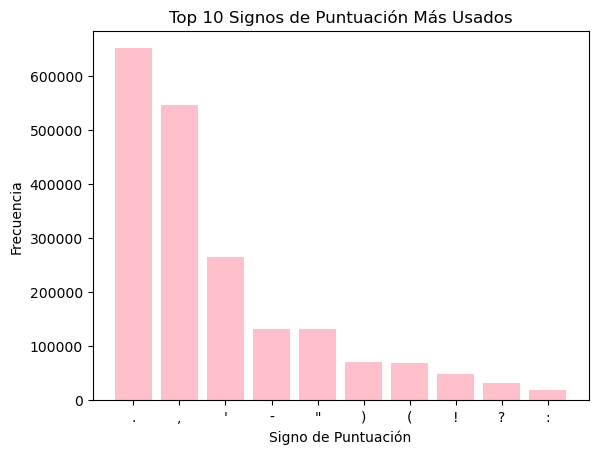

In [17]:
# Gráfico de los signos de puntuación más usados (Top 10)
top_punctuations = punctuation_counts.most_common(10)
punctuation_labels, punctuation_values = zip(*top_punctuations)

plt.bar(punctuation_labels, punctuation_values, color = 'pink')
plt.title("Top 10 Signos de Puntuación Más Usados")
plt.xlabel("Signo de Puntuación")
plt.ylabel("Frecuencia")

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/signos_puntuacion.pdf", bbox_inches = "tight")
plt.savefig("imagenes/signos_puntuacion.png", dpi = 300, bbox_inches = "tight")
plt.show()


### **Análisis del texto**

In [19]:
# Eliminar caracteres no alfanuméricos (excepto espacios)
def remove_non_alphanumeric(text):
    return re.sub(r"[^a-zA-Z\s]", "", text)


In [20]:
# Eliminar caracteres no alfanuméricos
full_df["cleaned_review"] = full_df["html_cleaned_review"].apply(remove_non_alphanumeric)


In [21]:
# Tokenización (eliminar signos de puntuación y convertir a minúsculas)
full_df["tokenized_review"] = full_df["cleaned_review"].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalnum()])


In [22]:
# Lematización
lemmatizer = WordNetLemmatizer()
full_df["lemmatized_review"] = full_df["tokenized_review"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])


In [23]:
# Eliminar stopwords
stop_words = set(stopwords.words('english'))
full_df["filtered_review"] = full_df["lemmatized_review"].apply(lambda tokens: [word for word in tokens if word not in stop_words])


In [24]:
full_df.head()

,review,sentiment,html_cleaned_review,cleaned_review,tokenized_review,lemmatized_review,filtered_review
0,For a movie that gets no respect there sure ar...,1,For a movie that gets no respect there sure ar...,For a movie that gets no respect there sure ar...,"[for, a, movie, that, gets, no, respect, there...","[for, a, movie, that, get, no, respect, there,...","[movie, get, respect, sure, lot, memorable, qu..."
1,Bizarre horror movie filled with famous faces ...,1,Bizarre horror movie filled with famous faces ...,Bizarre horror movie filled with famous faces ...,"[bizarre, horror, movie, filled, with, famous,...","[bizarre, horror, movie, filled, with, famous,...","[bizarre, horror, movie, filled, famous, face,..."
2,"A solid, if unremarkable film. Matthau, as Ein...",1,"A solid, if unremarkable film. Matthau, as Ein...",A solid if unremarkable film Matthau as Einste...,"[a, solid, if, unremarkable, film, matthau, as...","[a, solid, if, unremarkable, film, matthau, a,...","[solid, unremarkable, film, matthau, einstein,..."
3,It's a strange feeling to sit alone in a theat...,1,It's a strange feeling to sit alone in a theat...,Its a strange feeling to sit alone in a theate...,"[its, a, strange, feeling, to, sit, alone, in,...","[it, a, strange, feeling, to, sit, alone, in, ...","[strange, feeling, sit, alone, theater, occupi..."
4,"You probably all already know this by now, but...",1,"You probably all already know this by now, but...",You probably all already know this by now but ...,"[you, probably, all, already, know, this, by, ...","[you, probably, all, already, know, this, by, ...","[probably, already, know, additional, episode,..."


In [25]:
# Conteo de frecuencias de palabras más frecuentes
all_tokens = [word for tokens in full_df["filtered_review"] for word in tokens]
word_counts = Counter(all_tokens)


In [26]:
# Convertir a DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), 
                            columns=['word', 'frequency']).sort_values(by = 'frequency', ascending = False)

print(word_freq_df.head(20))

          word  frequency
0        movie      99026
127         wa      95207
124       film      89809
425        one      52677
156       like      39790
180         ha      33154
224       time      29397
394       good      28615
19   character      27573
1          get      24435
366       even      24286
171      story      24229
131      would      24001
132       make      23565
135        see      23494
76      really      22900
16       scene      20706
985       much      18897
55        well      18629
408     people      17979


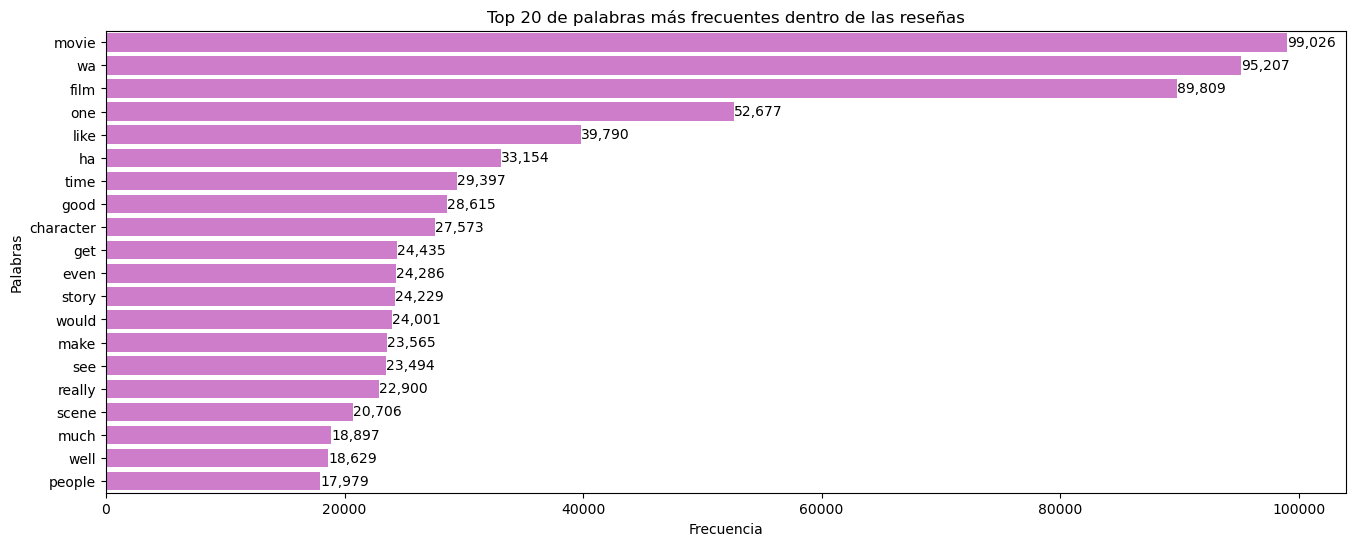

In [27]:
# Seleccionar las 20 palabras más frecuentes
top_words = word_freq_df.head(20)

# Configuración del tamaño del gráfico
plt.figure(figsize=(16, 6))

# Gráfica de barras horizontal
ax = sns.barplot(data=top_words, x = 'frequency', y = 'word', color = 'orchid')

# Agregar los conteos a cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}',  # Añadir formato con separación de miles
                (p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
                ha = 'left', va = 'center',
                fontsize = 10, color = 'black')

# Títulos y etiquetas
plt.title('Top 20 de palabras más frecuentes dentro de las reseñas')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')

# Guardar y mostrar el gráfico
if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/frecuencia_palabras_top20.pdf", bbox_inches="tight")
plt.savefig("imagenes/frecuencia_palabras_top20.png", dpi=300, bbox_inches="tight")
plt.show()

## **Análisis de sentimientos**

In [52]:
full_df.head()

,review,sentiment,html_cleaned_review,cleaned_review,tokenized_review,lemmatized_review,filtered_review
0,For a movie that gets no respect there sure ar...,1,For a movie that gets no respect there sure ar...,For a movie that gets no respect there sure ar...,"[for, a, movie, that, gets, no, respect, there...","[for, a, movie, that, get, no, respect, there,...","[movie, get, respect, sure, lot, memorable, qu..."
1,Bizarre horror movie filled with famous faces ...,1,Bizarre horror movie filled with famous faces ...,Bizarre horror movie filled with famous faces ...,"[bizarre, horror, movie, filled, with, famous,...","[bizarre, horror, movie, filled, with, famous,...","[bizarre, horror, movie, filled, famous, face,..."
2,"A solid, if unremarkable film. Matthau, as Ein...",1,"A solid, if unremarkable film. Matthau, as Ein...",A solid if unremarkable film Matthau as Einste...,"[a, solid, if, unremarkable, film, matthau, as...","[a, solid, if, unremarkable, film, matthau, a,...","[solid, unremarkable, film, matthau, einstein,..."
3,It's a strange feeling to sit alone in a theat...,1,It's a strange feeling to sit alone in a theat...,Its a strange feeling to sit alone in a theate...,"[its, a, strange, feeling, to, sit, alone, in,...","[it, a, strange, feeling, to, sit, alone, in, ...","[strange, feeling, sit, alone, theater, occupi..."
4,"You probably all already know this by now, but...",1,"You probably all already know this by now, but...",You probably all already know this by now but ...,"[you, probably, all, already, know, this, by, ...","[you, probably, all, already, know, this, by, ...","[probably, already, know, additional, episode,..."


In [54]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()


In [56]:
# Análisis de sentimiento con VADER
def get_sentiment(tokens):
    # Convertir la lista de palabras en texto plano
    text = " ".join(tokens)  
    sentiment_score = sia.polarity_scores(text)['compound']
    if sentiment_score >= 0:
        return "Positivo"
    elif sentiment_score < 0:
        return "Negativo"
        

In [58]:
# Aplicar el análisis de sentimiento y guardar en una nueva columna
full_df["predicted_sentiment"] = full_df["filtered_review"].apply(get_sentiment)


In [59]:
full_df.head()

,review,sentiment,html_cleaned_review,cleaned_review,tokenized_review,lemmatized_review,filtered_review,predicted_sentiment
0,For a movie that gets no respect there sure ar...,1,For a movie that gets no respect there sure ar...,For a movie that gets no respect there sure ar...,"[for, a, movie, that, gets, no, respect, there...","[for, a, movie, that, get, no, respect, there,...","[movie, get, respect, sure, lot, memorable, qu...",Positivo
1,Bizarre horror movie filled with famous faces ...,1,Bizarre horror movie filled with famous faces ...,Bizarre horror movie filled with famous faces ...,"[bizarre, horror, movie, filled, with, famous,...","[bizarre, horror, movie, filled, with, famous,...","[bizarre, horror, movie, filled, famous, face,...",Positivo
2,"A solid, if unremarkable film. Matthau, as Ein...",1,"A solid, if unremarkable film. Matthau, as Ein...",A solid if unremarkable film Matthau as Einste...,"[a, solid, if, unremarkable, film, matthau, as...","[a, solid, if, unremarkable, film, matthau, a,...","[solid, unremarkable, film, matthau, einstein,...",Positivo
3,It's a strange feeling to sit alone in a theat...,1,It's a strange feeling to sit alone in a theat...,Its a strange feeling to sit alone in a theate...,"[its, a, strange, feeling, to, sit, alone, in,...","[it, a, strange, feeling, to, sit, alone, in, ...","[strange, feeling, sit, alone, theater, occupi...",Positivo
4,"You probably all already know this by now, but...",1,"You probably all already know this by now, but...",You probably all already know this by now but ...,"[you, probably, all, already, know, this, by, ...","[you, probably, all, already, know, this, by, ...","[probably, already, know, additional, episode,...",Positivo


### **Comparar *sentiment* y *predicted_sentiment***

In [64]:
# Mapear etiquetas de texto a valores numéricos para comparación
full_df["predicted_sentiment_num"] = full_df["predicted_sentiment"].map({"Negativo": 0, 
                                                                         "Positivo": 1})


In [66]:
# Mostrar las primeras filas para comparar resultados
full_df[["review", "sentiment", "predicted_sentiment_num", "filtered_review"]].head()


,review,sentiment,predicted_sentiment_num,filtered_review
0,For a movie that gets no respect there sure ar...,1,1,"[movie, get, respect, sure, lot, memorable, qu..."
1,Bizarre horror movie filled with famous faces ...,1,1,"[bizarre, horror, movie, filled, famous, face,..."
2,"A solid, if unremarkable film. Matthau, as Ein...",1,1,"[solid, unremarkable, film, matthau, einstein,..."
3,It's a strange feeling to sit alone in a theat...,1,1,"[strange, feeling, sit, alone, theater, occupi..."
4,"You probably all already know this by now, but...",1,1,"[probably, already, know, additional, episode,..."


**Clases:**  
- Negative - 0
- Positive - 1

In [69]:
# Matriz de confusión
conf_matrix = confusion_matrix(
    full_df["sentiment"], 
    full_df["predicted_sentiment_num"]
)


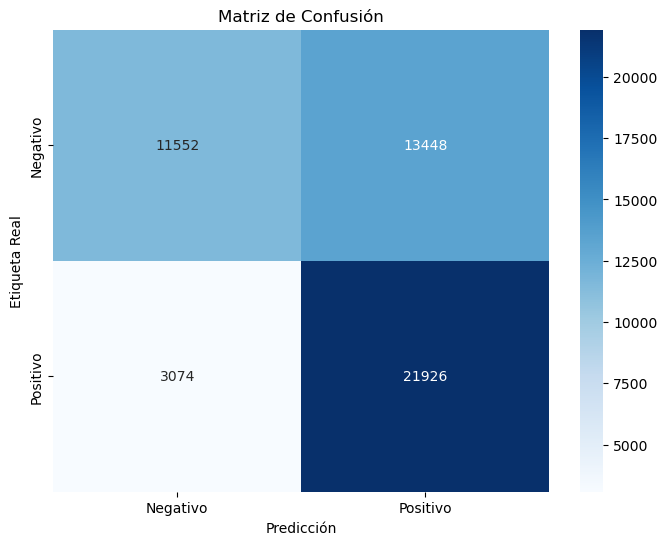

In [71]:
# Mostrar la matriz de confusión
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", 
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/matriz_confusion.pdf", bbox_inches = "tight")
plt.savefig("imagenes/matriz_confusion.png", dpi = 300, bbox_inches = "tight")
plt.show()


In [73]:
# Precisión global
accuracy = accuracy_score(full_df["sentiment"], full_df["predicted_sentiment_num"])
print(f"Precisión Global: {accuracy:.2%}")


Precisión Global: 66.96%


In [75]:
# Reporte de clasificación
print("\n Reporte de Clasificación: \n")
print(classification_report(full_df["sentiment"], 
                            full_df["predicted_sentiment_num"], 
                            target_names = ["Negativo", "Positivo"]))



 Reporte de Clasificación: 

              precision    recall  f1-score   support

    Negativo       0.79      0.46      0.58     25000
    Positivo       0.62      0.88      0.73     25000

    accuracy                           0.67     50000
   macro avg       0.70      0.67      0.65     50000
weighted avg       0.70      0.67      0.65     50000



In [78]:
# Filtrar las filas donde sentiment_label_num es diferente a predicted_sentiment_num
mismatched_reviews = full_df[full_df["sentiment"] != full_df["predicted_sentiment_num"]]

# Mostrar las primeras filas del nuevo DataFrame
mismatched_reviews[["review", "sentiment", "predicted_sentiment_num", "filtered_review"]].head()


,review,sentiment,predicted_sentiment_num,filtered_review
23,"To all the reviewers on this page, I would hav...",1,0,"[reviewer, page, would, say, movie, worth, see..."
33,James Stewart stars in a classic western tale ...,1,0,"[james, stewart, star, classic, western, tale,..."
35,One of the most nihilistic and brutal films I'...,1,0,"[one, nihilistic, brutal, film, ive, ever, see..."
40,"Mesmerizing, breathtaking and horrifying, this...",1,0,"[mesmerizing, breathtaking, horrifying, haunti..."
45,Henri Verneuil's film may be not so famous as ...,1,0,"[henri, verneuils, film, may, famous, parallax..."


In [80]:
# Guardar el DataFrame en un archivo CSV
mismatched_reviews.to_csv("mismatched_reviews.csv", index = False)
